
# K‑Medoids Clustering (PAM) — Beginner-Friendly Notebook

This notebook implements **K‑Medoids** (Partitioning Around Medoids, PAM) from scratch using NumPy.
You'll learn how it differs from K‑Means, how to run it on a toy dataset, and how to visualize the result.

**Why K‑Medoids?**
- Uses **actual data points** as centers (medoids), not means.
- Works with **any distance** (e.g., Euclidean, Manhattan), and is **robust to outliers**.
- Optimizes the **sum of distances** from points to their cluster medoid.

What we'll do:
1. Make a small 2D dataset
2. Implement a general **distance matrix** helper
3. Implement **PAM** (build + swap) for K‑Medoids
4. Run, visualize clusters & medoids, and check the total cost
5. (Optional) Try a different distance (Manhattan) and compare


In [1]:

import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(10)



## 1) Create a simple 2D dataset


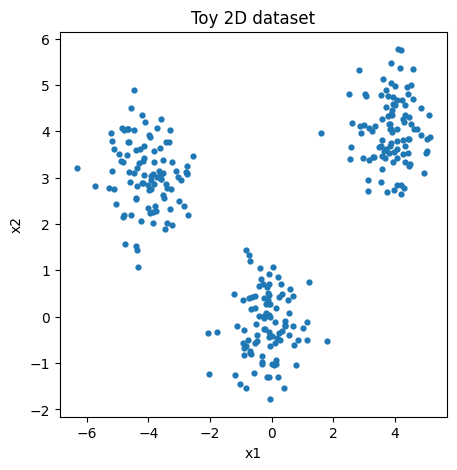

In [2]:

def make_blobs(n_per_cluster=100, centers=None, spread=0.7, random_state=10):
    if centers is None:
        centers = [(0,0), (4,4), (-4,3)]
    rng_local = np.random.default_rng(random_state)
    X_parts = []
    for cx, cy in centers:
        X_parts.append(rng_local.normal(loc=(cx, cy), scale=spread, size=(n_per_cluster, 2)))
    X = np.vstack(X_parts)
    return X

X = make_blobs(n_per_cluster=100, centers=[(0,0), (4,4), (-4,3)], spread=0.7, random_state=10)

plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], s=12)
plt.title("Toy 2D dataset")
plt.xlabel("x1"); plt.ylabel("x2")
plt.show()



## 2) Distance matrix helper

We'll support **Euclidean** and **Manhattan** distances. You can plug in your own metric if needed.


In [3]:

def pairwise_distance(X, metric="euclidean"):
    """
    Returns an (n x n) distance matrix for X.
    metric: "euclidean" or "manhattan"
    """
    X = np.asarray(X, dtype=float)
    n = X.shape[0]
    if metric == "euclidean":
        # (x - y)^2 = x^2 + y^2 - 2xy trick
        G = X @ X.T
        sq_norms = np.sum(X*X, axis=1)
        dist2 = sq_norms[:,None] + sq_norms[None,:] - 2*G
        dist2 = np.maximum(dist2, 0.0)
        return np.sqrt(dist2)
    elif metric == "manhattan":
        # broadcasted L1
        diffs = X[:,None,:] - X[None,:,:]  # (n,n,d)
        return np.sum(np.abs(diffs), axis=2)
    else:
        raise ValueError("Unsupported metric")



## 3) K‑Medoids (PAM) implementation

**High‑level steps:**
- **Build**: pick an initial set of `k` medoids (here we do a simple greedy init).
- **Assign**: assign each point to its **nearest medoid**.
- **Swap**: try swapping a medoid with a non‑medoid point; keep swap if it **reduces total cost**.
- Repeat assign+swap until no improvement (or we hit `max_iter`).


In [4]:

def total_cost(D, medoid_indices, labels):
    """Sum of distances from each point to its assigned medoid (using distance matrix D)."""
    costs = D[np.arange(D.shape[0]), medoid_indices[labels]]
    return float(np.sum(costs))

def assign_labels(D, medoid_indices):
    """Assign each point to the nearest medoid; return labels and min distances."""
    # distances to each medoid: (n, k)
    dist_to_medoids = D[:, medoid_indices]
    labels = np.argmin(dist_to_medoids, axis=1)
    dmin = dist_to_medoids[np.arange(D.shape[0]), labels]
    return labels, dmin

def greedy_build(D, k, rng):
    """Greedy initialization: start with a random medoid, then add points that reduce cost most."""
    n = D.shape[0]
    # pick 1st medoid randomly
    medoids = [int(rng.integers(0, n))]
    labels, dmin = assign_labels(D, medoids)

    while len(medoids) < k:
        best_gain = -np.inf
        best_candidate = None

        # try adding each non-medoid as candidate
        for i in range(n):
            if i in medoids:
                continue
            # new distance if i were a medoid
            new_dmin = np.minimum(dmin, D[:, i])
            gain = np.sum(dmin - new_dmin)  # reduction in cost
            if gain > best_gain:
                best_gain = gain
                best_candidate = i

        medoids.append(best_candidate)
        # update dmin, labels
        labels, dmin = assign_labels(D, medoids)

    return np.array(medoids, dtype=int)

def pam(X, k=3, metric="euclidean", max_iter=100, random_state=0, verbose=True):
    """
    Partitioning Around Medoids (PAM) using a distance matrix.
    Returns: medoid_indices, labels, cost_history
    """
    rng_local = np.random.default_rng(random_state)
    D = pairwise_distance(X, metric=metric)
    n = D.shape[0]

    # Build phase (greedy)
    medoid_indices = greedy_build(D, k, rng_local)

    labels, dmin = assign_labels(D, medoid_indices)
    cost = float(np.sum(dmin))
    cost_history = [cost]

    if verbose:
        print(f"[init] cost = {cost:.4f}, medoids = {medoid_indices.tolist()}")

    # Swap phase
    for it in range(1, max_iter+1):
        improved = False
        for m_pos in range(k):
            m_idx = medoid_indices[m_pos]
            # try swapping medoid m_idx with any non-medoid h
            for h in range(n):
                if h in medoid_indices:
                    continue
                # compute new labels/cost WITHOUT recomputing everything from scratch
                # Fast trick: recompute distances to candidate h only
                new_medoids = medoid_indices.copy()
                new_medoids[m_pos] = h

                new_labels, new_dmin = assign_labels(D, new_medoids)
                new_cost = float(np.sum(new_dmin))

                if new_cost + 1e-12 < cost:  # strict improvement
                    medoid_indices = new_medoids
                    labels = new_labels
                    dmin = new_dmin
                    cost = new_cost
                    cost_history.append(cost)
                    improved = True
                    if verbose:
                        print(f"[iter {it}] swap {m_idx} -> {h} | cost = {cost:.4f}")
                    break  # accept first improving swap
            if improved:
                break
        if not improved:
            if verbose:
                print(f"[stop] no improving swap found at iter {it}. Final cost = {cost:.4f}")
            break

    return medoid_indices, labels, cost_history, D



## 4) Run K‑Medoids and inspect results


In [5]:

# === Parameters you can tweak ===
k = 3
metric = "euclidean"   # try "manhattan"
max_iter = 100
random_state = 0
verbose = True
# ================================

medoids, labels, cost_hist, D = pam(
    X, k=k, metric=metric, max_iter=max_iter, random_state=random_state, verbose=verbose
)

print("Medoid indices:", medoids)
print("Final cost:", cost_hist[-1])
print("Cost history length:", len(cost_hist))


[init] cost = 271.7891, medoids = [255, 128, 6]
[iter 1] swap 255 -> 222 | cost = 271.1479
[iter 2] swap 222 -> 243 | cost = 269.7773
[iter 3] swap 243 -> 252 | cost = 269.2006
[iter 4] swap 128 -> 103 | cost = 266.6023
[iter 5] swap 103 -> 104 | cost = 265.6664
[iter 6] swap 104 -> 106 | cost = 262.9488
[iter 7] swap 106 -> 113 | cost = 261.3950
[iter 8] swap 113 -> 171 | cost = 261.2813
[stop] no improving swap found at iter 9. Final cost = 261.2813
Medoid indices: [252 171   6]
Final cost: 261.281342172855
Cost history length: 9



## 5) Visualize clusters and medoids


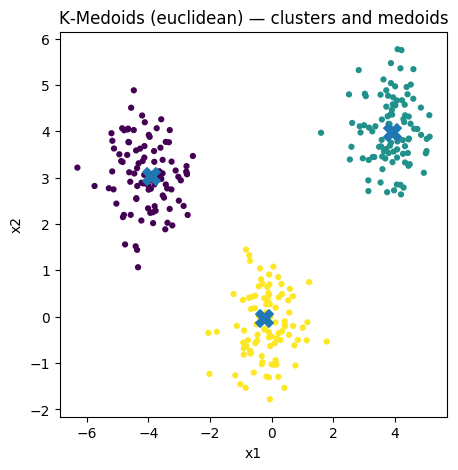

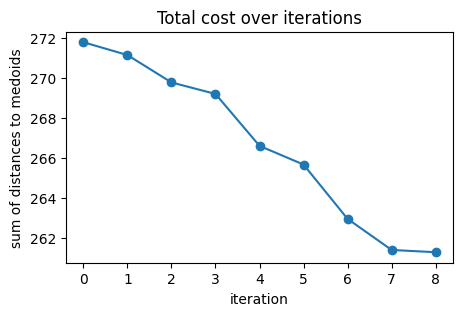

In [6]:

# Scatter with labels and highlight medoids
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], s=12, c=labels)
plt.scatter(X[medoids,0], X[medoids,1], s=160, marker='X')
plt.title(f"K‑Medoids ({metric}) — clusters and medoids")
plt.xlabel("x1"); plt.ylabel("x2")
plt.show()

# Plot cost over swap iterations
plt.figure(figsize=(5,3))
plt.plot(cost_hist, marker='o')
plt.title("Total cost over iterations")
plt.xlabel("iteration"); plt.ylabel("sum of distances to medoids")
plt.show()



## 6) (Optional) Try Manhattan distance for robustness


Manhattan final cost: 327.1523358851912


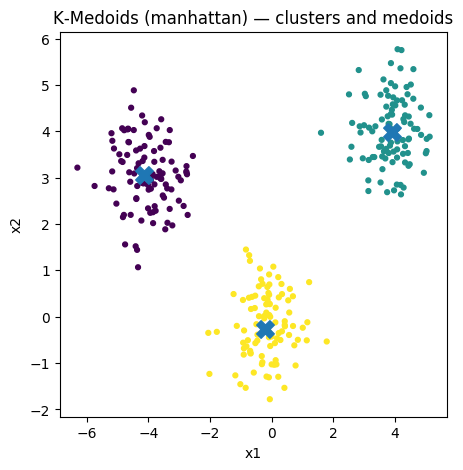

In [7]:

medoids_m, labels_m, cost_hist_m, D_m = pam(
    X, k=k, metric="manhattan", max_iter=max_iter, random_state=random_state, verbose=False
)
print("Manhattan final cost:", cost_hist_m[-1])

plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], s=12, c=labels_m)
plt.scatter(X[medoids_m,0], X[medoids_m,1], s=160, marker='X')
plt.title("K‑Medoids (manhattan) — clusters and medoids")
plt.xlabel("x1"); plt.ylabel("x2")
plt.show()



## 7) Assigning new points to nearest medoid


In [8]:

def assign_new_points(X_new, X_train, medoid_indices, metric="euclidean"):
    """
    Given fitted medoids on X_train, assign new points in X_new to nearest medoid.
    """
    X_new = np.asarray(X_new, dtype=float)
    meds = X_train[medoid_indices]
    if metric == "euclidean":
        # compute pairwise distances X_new vs meds
        # (a - b)^2 trick expanded for cross distances
        a2 = np.sum(X_new*X_new, axis=1)[:,None]
        b2 = np.sum(meds*meds, axis=1)[None,:]
        cross = X_new @ meds.T
        dist2 = a2 + b2 - 2*cross
        dist2 = np.maximum(dist2, 0.0)
        d = np.sqrt(dist2)
    elif metric == "manhattan":
        diffs = X_new[:,None,:] - meds[None,:,:]
        d = np.sum(np.abs(diffs), axis=2)
    else:
        raise ValueError("Unsupported metric")
    labels_new = np.argmin(d, axis=1)
    return labels_new

# Example: label 3 new points
X_new = np.array([[0,0], [3.5,3.1], [-4.2, 3.4]])
labels_new = assign_new_points(X_new, X, medoids, metric=metric)
print("New points labels:", labels_new)


New points labels: [2 1 0]



## 8) Practical tips & next steps

- **Choosing k**: Try different k and compare total cost or silhouette score.
- **Initialization**: We used a simple greedy build; you can also try random starts and keep the best.
- **Distance**: Swap `metric` to match your data (Euclidean/Manhattan shown here).
- **Scaling**: Standardize features if they are on very different scales.
- **Complexity**: PAM can be slower on large datasets. For speed, look into **CLARA** or **CLARANS** variants.

Happy clustering!
